In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
from scvi.data import pbmc_seurat_v4_cite_seq
from scvi.model import TOTALVI
import sys
import numpy as np
import pickle
from copy import deepcopy
import numpy as np
import pandas as pd

import cosg as cosg
import importlib
import time
importlib.reload(cosg)

/home/ubartu/miniconda3/envs/hap/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ubartu/miniconda3/envs/hap/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


<module 'cosg' from '/home/ubartu/miniconda3/envs/hap/lib/python3.9/site-packages/cosg/__init__.py'>

In [2]:
dataLoc = './data/'
adata = pbmc_seurat_v4_cite_seq(save_path=dataLoc, apply_filters=True, aggregate_proteins=True, mask_protein_batches=0)

adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
adata.obs_names_make_unique()

INFO     File ./data/pbmc_seurat_v4.h5ad already downloaded                                                        


In [3]:
# Remove the CD14 Mono cells
adata = adata[adata.obs['celltype.l2'] != 'CD14 Mono', :]
adata

View of AnnData object with n_obs × n_vars = 110942 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size'
    var: 'mt'
    obsm: 'protein_counts'
    layers: 'counts'

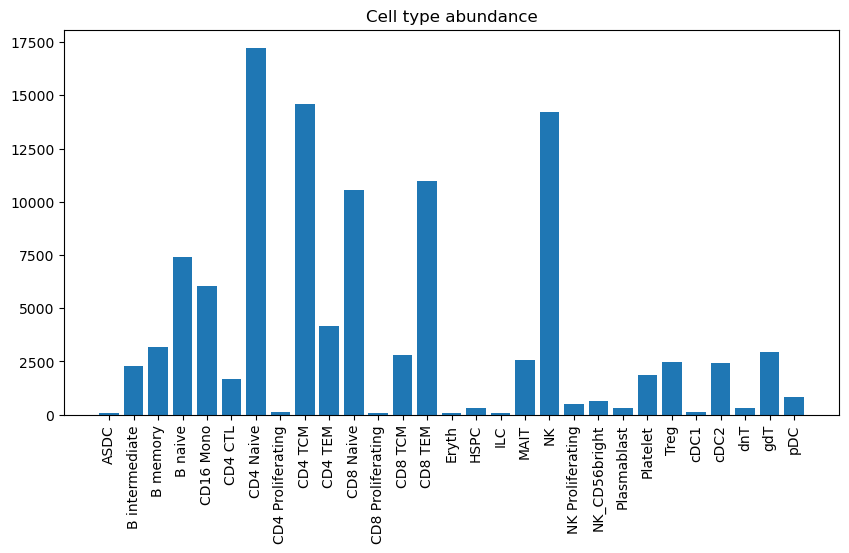

In [21]:
# Get the cell type abundance
cellType = adata.obs['celltype.l2'].unique()
cellType = cellType[~pd.isna(cellType)]
cellType = np.sort(cellType)
cellTypeAbundance = adata.obs['celltype.l2'].value_counts()
cellTypeAbundance = cellTypeAbundance[cellType]

# # Sort the cell types by abundance
# cellType = cellType[np.argsort(cellTypeAbundance)]
# cellTypeAbundance = cellTypeAbundance[np.argsort(cellTypeAbundance)]

# Create a plot of the cell type abundance, sorted by abundance
plt.figure(figsize=(10, 5))
plt.bar(cellType, cellTypeAbundance)
plt.xticks(rotation=90)
plt.title('Cell type abundance')
plt.show()



In [5]:
protein_adata = ad.AnnData(adata.obsm["protein_counts"])
protein_adata.obs_names = adata.obs_names
del adata.obsm["protein_counts"]
# mdata = md.MuData({"rna": adata, "protein": protein_adata})
# mdata.var_names_make_unique()

/tmp/ipykernel_46560/4127326056.py:3: ImplicitModificationWarning: Removing element `.obsm['protein_counts']` of view, initializing view as actual.
  del adata.obsm["protein_counts"]


In [6]:
np.unique(adata.obs['celltype.l2'])

array(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD16 Mono',
       'CD4 CTL', 'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM',
       'CD8 Naive', 'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'Eryth',
       'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating', 'NK_CD56bright',
       'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT',
       'pDC'], dtype=object)

In [7]:
print(len(np.unique(adata.obs['celltype.l2'])))

29


In [8]:
help(cosg.cosg)

Help on function cosg in module cosg.cosg:

cosg(adata, groupby='CellTypes', groups: Union[Literal['all'], Iterable[str]] = 'all', mu=1, remove_lowly_expressed: bool = False, expressed_pct: Optional[float] = 0.1, n_genes_user: int = 50, key_added: Optional[str] = None, use_raw: bool = True, layer: Optional[str] = None, reference: str = 'rest', copy: bool = False)
    Marker gene identification for single-cell sequencing data using COSG.
    
    Parameters
    ----------
    adata
        Annotated data matrix. Note: input paramters are simliar to the parameters used for scanpy's rank_genes_groups() function.
    groupby
        The key of the cell groups in .obs, the default value is set to 'CellTypes'.
    groups
        Subset of cell groups, e.g. [`'g1'`, `'g2'`, `'g3'`], to which comparison shall be restricted. The default value is 'all', and all groups will be compared.
    mu
        The penalty restricting marker genes expressing in non-target cell groups. Larger value represen

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
t0= time.time()
cosg.cosg(adata,
    key_added='cosg',
        mu=1,
        n_genes_user=30,
        groupby='celltype.l2')
runtime_cosg = time.time() - t0
print(runtime_cosg)

**finished identifying marker genes by COSG**
2.8556392192840576


In [11]:
# Get COSG scores
cosg_scores = pd.DataFrame(adata.uns['cosg']['scores'])
cosg_scores

,ASDC,B intermediate,B memory,B naive,CD16 Mono,CD4 CTL,CD4 Naive,CD4 Proliferating,CD4 TCM,CD4 TEM,...,NK Proliferating,NK_CD56bright,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0.367609,0.364097,0.528704,0.847743,0.869617,0.097331,0.482338,0.226904,0.247666,0.058371,...,0.482285,0.490972,0.650962,0.931851,0.413621,0.889386,0.814974,0.247898,0.363895,0.836711
1,0.283386,0.223213,0.527090,0.818793,0.868288,0.054493,0.333700,0.162786,0.239901,0.054636,...,0.426406,0.289207,0.508689,0.930615,0.309518,0.759790,0.806826,0.102060,0.230837,0.804198
2,0.218403,0.214664,0.495736,0.681026,0.852277,0.051510,0.332980,0.134220,0.221224,0.039671,...,0.381939,0.217480,0.429271,0.924550,0.157110,0.729771,0.697030,0.098039,0.193831,0.786268
3,0.209467,0.211697,0.476955,0.639212,0.846614,0.036483,0.322243,0.125383,0.210437,0.032063,...,0.372690,0.185326,0.407379,0.918453,0.155006,0.600283,0.611550,0.095888,0.162071,0.771527
4,0.129726,0.185015,0.391045,0.573750,0.830496,0.029967,0.291861,0.124091,0.207891,0.030526,...,0.351972,0.169562,0.350121,0.913962,0.127460,0.507414,0.554800,0.089088,0.098869,0.741116
5,0.093455,0.172023,0.376677,0.532587,0.808074,0.028906,0.256530,0.123167,0.184304,0.030248,...,0.347210,0.126881,0.260200,0.899974,0.124086,0.461397,0.532699,0.084411,0.059046,0.699393
6,0.091875,0.150586,0.310281,0.511413,0.806740,0.028755,0.255493,0.122650,0.169880,0.030240,...,0.344907,0.123962,0.255695,0.896648,0.103274,0.432124,0.524845,0.067295,0.049123,0.694390
7,0.083080,0.127458,0.291080,0.494067,0.804300,0.025391,0.246232,0.120385,0.162722,0.029782,...,0.337670,0.109060,0.252742,0.895292,0.089233,0.400404,0.515768,0.059498,0.045741,0.668779
8,0.080283,0.122273,0.290692,0.493686,0.791101,0.024850,0.243180,0.116506,0.155325,0.029069,...,0.334646,0.108727,0.245319,0.885300,0.076086,0.375058,0.493363,0.055939,0.041864,0.664030
9,0.075660,0.110866,0.283748,0.485249,0.786552,0.022882,0.214123,0.116379,0.153351,0.027788,...,0.331464,0.091123,0.234661,0.873585,0.067905,0.319001,0.459641,0.052070,0.037282,0.663023


In [22]:
cellTypeAbundance

ASDC                    74
B intermediate        2294
B memory              3168
B naive               7399
CD16 Mono             6065
CD4 CTL               1667
CD4 Naive            17223
CD4 Proliferating      103
CD4 TCM              14606
CD4 TEM               4178
CD8 Naive            10533
CD8 Proliferating       87
CD8 TCM               2820
CD8 TEM              10959
Eryth                   74
HSPC                   320
ILC                     95
MAIT                  2584
NK                   14217
NK Proliferating       508
NK_CD56bright          659
Plasmablast            331
Platelet              1852
Treg                  2468
cDC1                   147
cDC2                  2431
dnT                    311
gdT                   2933
pDC                    836
Name: celltype.l2, dtype: int64

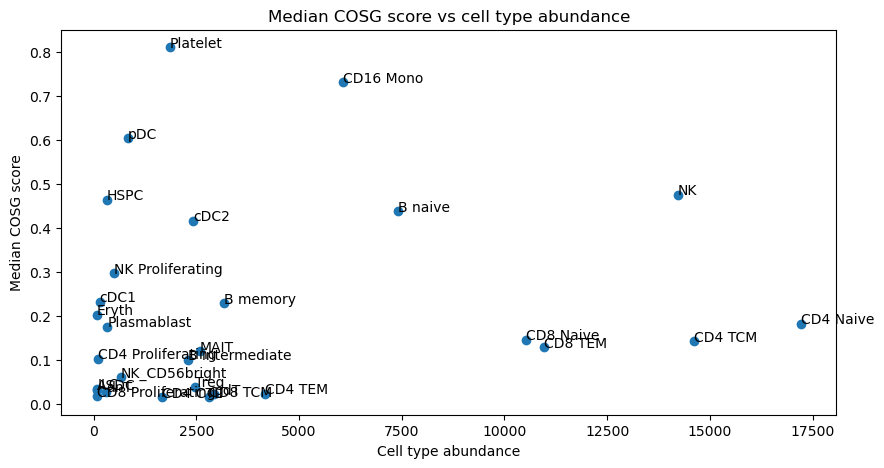

In [23]:
# For each column, get the median COSG score
cosg_scores_median = cosg_scores.median(axis=0)

# Plot the median COSG score for each cell type over the abundance of that cell type
plt.figure(figsize=(10, 5))
plt.scatter(cellTypeAbundance, cosg_scores_median)
plt.xlabel('Cell type abundance')
plt.ylabel('Median COSG score')
plt.title('Median COSG score vs cell type abundance')

# For each point in the plot, annotate with the cell type name
for i, txt in enumerate(cellType):
    plt.annotate(txt, (cellTypeAbundance[i], cosg_scores_median[i]))
plt.show()

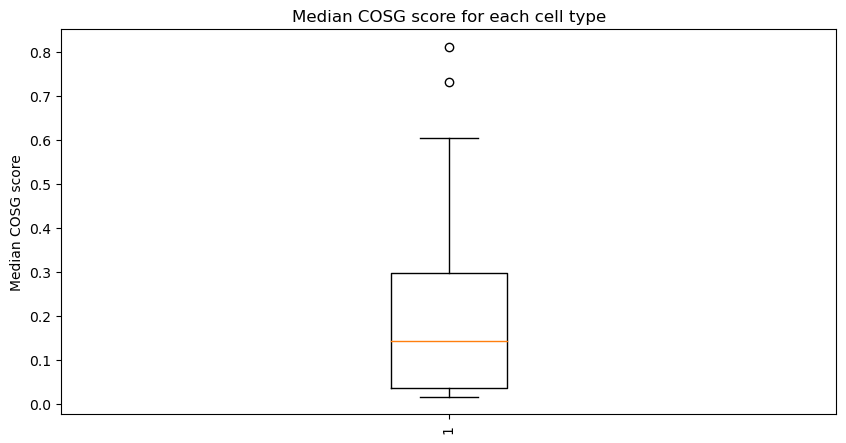

In [25]:
# Create a boxplot of the median COSG score for each cell type
plt.figure(figsize=(10, 5))
plt.boxplot(cosg_scores_median)
plt.xticks(rotation=90)
plt.ylabel('Median COSG score')
plt.title('Median COSG score for each cell type')
plt.show()

In [45]:
# Load in cosgs scores with all cells
cosg_scores_all = pd.read_csv('./data/cosg_30_markergenes_scores.csv', index_col=0)

# Remove the CD14 Mono column
# cosg_scores_all = cosg_scores_all.drop(columns='CD14 Mono')

In [46]:
cosg_scores_all

,ASDC,B intermediate,B memory,B naive,CD14 Mono,CD16 Mono,CD4 CTL,CD4 Naive,CD4 Proliferating,CD4 TCM,...,NK Proliferating,NK_CD56bright,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0.326058,0.359170,0.526844,0.845176,0.931796,0.810287,0.054168,0.463275,0.216759,0.246266,...,0.473298,0.488121,0.643792,0.892406,0.404624,0.870408,0.792119,0.236907,0.361598,0.824762
1,0.217528,0.220725,0.525163,0.816679,0.922466,0.671751,0.051093,0.331699,0.156199,0.236844,...,0.404121,0.287552,0.457675,0.888732,0.305991,0.640853,0.656387,0.096887,0.229920,0.768761
2,0.197680,0.210137,0.478175,0.665411,0.888860,0.565671,0.036298,0.320435,0.122069,0.218282,...,0.363409,0.211698,0.408931,0.880401,0.155627,0.636943,0.586609,0.096211,0.192809,0.762590
3,0.185476,0.194149,0.471053,0.632442,0.880823,0.527112,0.029967,0.290966,0.119799,0.206501,...,0.344984,0.182879,0.401996,0.880293,0.148755,0.507414,0.493633,0.095364,0.161325,0.735469
4,0.122751,0.184044,0.375485,0.571850,0.866031,0.498538,0.028785,0.254552,0.119302,0.205551,...,0.338782,0.168985,0.343635,0.875685,0.122851,0.451077,0.485057,0.082460,0.098535,0.734856
5,0.092359,0.171178,0.349982,0.506284,0.854064,0.484311,0.025853,0.253827,0.118347,0.182887,...,0.338529,0.124880,0.255695,0.863019,0.122225,0.447645,0.433769,0.066856,0.058678,0.682414
6,0.077430,0.120358,0.308992,0.499976,0.821177,0.465817,0.025694,0.242100,0.113599,0.161843,...,0.334493,0.116722,0.254571,0.860381,0.102093,0.371478,0.363986,0.058916,0.048967,0.663608
7,0.065843,0.116399,0.283834,0.492710,0.819685,0.426158,0.025331,0.241702,0.113237,0.151979,...,0.321076,0.108242,0.233341,0.857006,0.087502,0.307695,0.328058,0.055697,0.042476,0.655648
8,0.062954,0.109312,0.283165,0.492065,0.817465,0.379007,0.024739,0.219529,0.109245,0.142086,...,0.319599,0.090762,0.227711,0.829722,0.075133,0.272124,0.289922,0.051264,0.041385,0.649251
9,0.049636,0.104582,0.277102,0.480773,0.803065,0.371849,0.022784,0.213173,0.108288,0.141926,...,0.312024,0.087663,0.221655,0.829421,0.059968,0.268378,0.254881,0.046828,0.036972,0.626386


Statistics=447.000, p=0.862


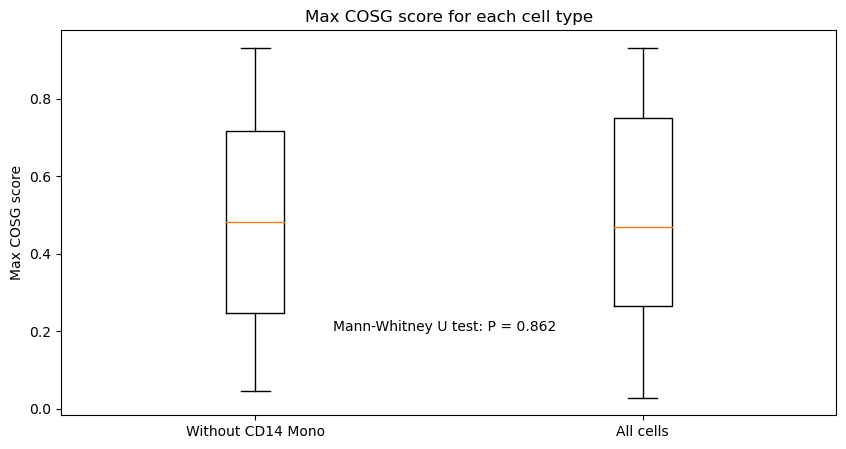

In [49]:
cosg_scores_all_median = cosg_scores_all.median(axis=0)
cosg_scores_all_max = cosg_scores_all.max(axis=0)
cosg_scores_max = cosg_scores.max(axis=0)

# Compare the boxplots of the median COSG scores for each cell type
plt.figure(figsize=(10, 5))
plt.boxplot([cosg_scores_max, cosg_scores_all_max], labels=['Without CD14 Mono', 'All cells'])
plt.ylabel('Max COSG score')
plt.title('Max COSG score for each cell type')

# Perform a Mann-Whitney U test to compare the median COSG scores for each cell type
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(cosg_scores_max, cosg_scores_all_max)
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Add the P value to the plot
plt.text(1.2, 0.2, 'Mann-Whitney U test: P = %.3f' % p)

plt.show()

In [15]:
marker_gene=pd.DataFrame(adata.uns['cosg']['names'])
marker_gene

,ASDC,B intermediate,B memory,B naive,CD16 Mono,CD4 CTL,CD4 Naive,CD4 Proliferating,CD4 TCM,CD4 TEM,...,NK Proliferating,NK_CD56bright,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,AXL,LINC01857,LINC01781,TCL1A,MS4A7,PROK2,FHIT,CCNB2,AQP3,GZMK,...,TYMS,SPTSSB,TNFRSF17,CAVIN2,FOXP3,CLEC9A,FCER1A,PTPN3,TRDV2,CLEC4C
1,HAMP,SOX5,SSPN,IGHD,SMIM25,TRBV18,IL6ST,DLGAP5,TNFRSF4,CCR9,...,CLSPN,XCL1,TXNDC5,TUBB1,RTKN2,XCR1,CLEC10A,FXYD2,TRDV1,LILRA4
2,SIGLEC6,KLK1,COCH,FCER2,CDKN1C,GFPT2,TSHZ2,PLK1,NEFL,DPP4,...,TK1,TNFRSF11A,IGF1,PF4,LINC01281,IDO1,ENHO,AC079341.1,TRGC1,SERPINF1
3,ATP1A2,GPM6A,TEX9,IGHM,SERPINA1,TRBV10-2,ADTRP,HMMR,AP3M2,TNFAIP3,...,CKAP2L,KIR2DL4,GLDC,PPBP,FANK1,RAB7B,CACNA2D3,MIR4422HG,TRDC,LRRC26
4,PLS3,FCRL2,AIM2,FCRL1,CFD,TRBV5-6,CCR7,CENPA,TTC39C-AS1,IFNG-AS1,...,DTL,PPP1R9A,SDC1,GNG11,ARG1,PPY,CD1C,IL10,TRGV9,SCT
5,CDH1,TNFRSF13B,SHISA8,PLPP5,TCF7L2,TRAV38-1,TRABD2A,CEP55,INPP4B,IGFBP3,...,CDC45,IGFBP4,AC106897.1,SPARC,IL2RA,ENPP1,LGALS2,OGN,TRGC2,LAMP5
6,BICC1,ARHGAP24,BTNL9,CD22,LRRC25,LINC01793,LEF1,CDC20,TRADD,SLAMF1,...,MCM10,ADGRG3,SPACA3,CLU,AC133644.2,TACSTD2,PKIB,GDF10,TRDV3,EPHB1
7,CCDC188,CLECL1,IGHG1,PCDH9,LILRB2,TRAV17,ANKRD55,KIF20A,CD40LG,IL7R,...,PKMYT1,CDHR1,NT5DC2,GP9,RBMS3,C1orf54,CD1E,AC004585.1,TRGV5,LINC00996
8,CTSV,GALNTL6,IGHG3,COL19A1,C5AR1,KIF19,CHRM3-AS2,CDKN3,GPR183,CD40LG,...,UHRF1,BMP2,GPRC5D,PRKAR2B,CTLA4,CLNK,CYP2S1,AC006058.1,CYP24A1,TNFRSF21
9,AL008721.1,AC104024.1,IGHA2,LINC00926,PILRA,GZMH,MAL,UBE2C,ST6GALNAC1,CYB561,...,MKI67,ZMAT4,MIXL1,TREML1,ICA1,SEPT3,VEGFA,CAV1,KLRG1,SMPD3


In [16]:
marker_gene.to_csv('./data/cosg_30_markergenes.csv')

In [17]:
marker_gene_names = marker_gene.values.flatten().tolist()
marker_gene_names = np.array(marker_gene_names, dtype=str)
marker_gene_names.shape

(870,)

In [18]:
org_genes = pd.read_csv('./data/cosg_30_markergenes_orig.csv', index_col=0)
org_genes = org_genes.values.flatten().tolist()
org_genes = np.array(org_genes, dtype='str')
org_genes.shape

(900,)

In [19]:
len(np.intersect1d(org_genes, marker_gene_names))

674